<a href="https://www.kaggle.com/code/yashmaini/road-analysis?scriptVersionId=216967701" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install osmnx networkx matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 2.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.14.4
    Uninstalling geopandas-0.14.4:
      Successfully uninstalled geopandas-0.14.4


In [26]:
import osmnx as ox
import networkx as nx
import numpy as np
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point

In [5]:
def calculate_road_circularity(place_name, distance=5000):
    # Calculate the average and median circularity of roads in a given area.
    
    G = ox.graph_from_address(place_name, dist=distance, network_type='drive')  # Load the road network
    edges = ox.graph_to_gdfs(G, nodes=False, edges=True)  # Convert to GeoDataFrame

    circularities = []
    for edge in edges.geometry:
        if isinstance(edge, LineString):
            length = edge.length  # Length of the road
            start, end = edge.coords[0], edge.coords[-1]
            straight_line_distance = LineString([start, end]).length  # Straight-line distance

            if straight_line_distance > 0:
                circularities.append(length / straight_line_distance)  # Circularity

    return {
        "city": place_name,  # Name of the analyzed area
        "average_circularity": np.mean(circularities),  # Average circularity of roads
        "median_circularity": np.median(circularities),  # Median circularity of roads
        "num_segments": len(circularities),  # Number of road segments analyzed
    }


In [13]:
cities = ["Karol Bagh, Delhi, India", "Delhi, India"] 
results = []
for city in cities:
  city_circularity = calculate_road_circularity(city)
  results.append(city_circularity)
  print(f"{city} Road Circularity: {city_circularity}")

Karol Bagh, Delhi, India Road Circularity: {'city': 'Karol Bagh, Delhi, India', 'average_circularity': 1.0353416309814814, 'median_circularity': 1.0, 'num_segments': 38328}
Delhi, India Road Circularity: {'city': 'Delhi, India', 'average_circularity': 1.041844301902935, 'median_circularity': 1.0, 'num_segments': 30333}


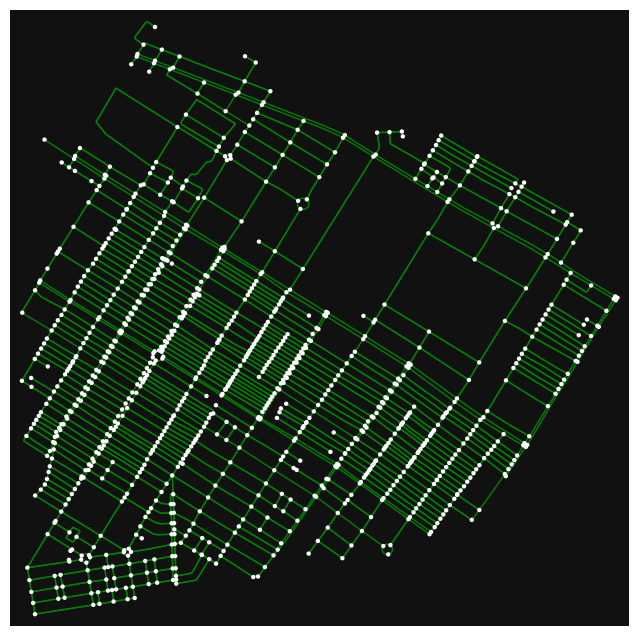

In [9]:
place = "Karol Bagh, Delhi, India"
graph = ox.graph_from_place(place, network_type='drive')
fig, ax = ox.plot_graph(graph, node_size=10, edge_color="green")


Top 5 nodes by betweenness centrality:
Node 10598455898: 0.1412
Node 10598455893: 0.1303
Node 1869899501: 0.1280
Node 943640708: 0.1254
Node 943640939: 0.1091

Top 5 edges by betweenness centrality:
Edge (10598455893, 1869899501): 0.0759
Edge (9841262325, 10598455893): 0.0726
Edge (10598455896, 10598455899): 0.0640
Edge (10598455898, 943640708): 0.0636
Edge (6730511851, 6730511854): 0.0610


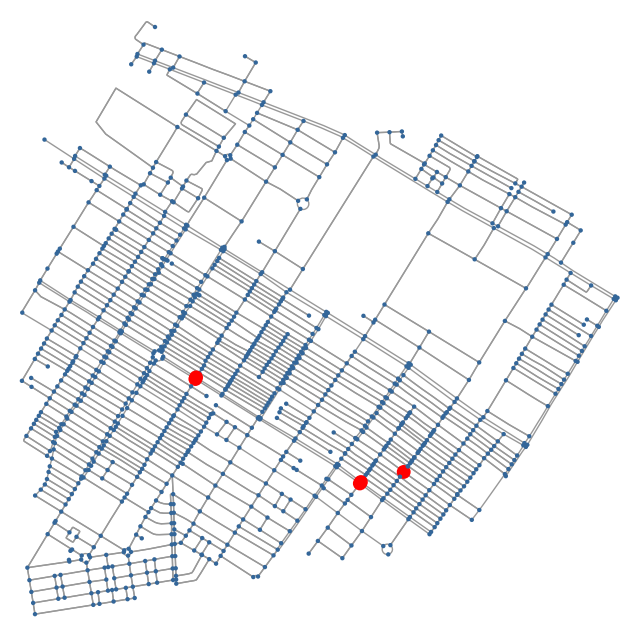

In [19]:
# Load the graph for Karol Bagh, Delhi
place = "Karol Bagh, Delhi, India"
graph = ox.graph_from_place(place, network_type='drive')

# Convert MultiDiGraph to DiGraph for centrality calculations
digraph = nx.DiGraph(graph)

# Calculate centralities
node_betweenness = nx.betweenness_centrality(digraph, normalized=True, weight='length')
edge_betweenness = nx.edge_betweenness_centrality(digraph, normalized=True, weight='length')

# Get top nodes and edges
top_nodes = sorted(node_betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
top_edges = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)[:5]

# Print results with formatted output
print("\nTop 5 nodes by betweenness centrality:")
for node_id, centrality in top_nodes:
    print(f"Node {node_id}: {centrality:.4f}")

print("\nTop 5 edges by betweenness centrality:")
for edge, centrality in top_edges:
    print(f"Edge {edge}: {centrality:.4f}")

# Visualize the network with high betweenness nodes highlighted
nc = ['r' if node in dict(top_nodes) else '#336699' for node in digraph.nodes()]
ns = [100 if node in dict(top_nodes) else 10 for node in digraph.nodes()]

# Plot the graph
fig, ax = ox.plot_graph(graph, node_color=nc, node_size=ns, node_zorder=2, bgcolor="white")


Road Type Distribution:
highway
residential      1409
tertiary         1250
primary            31
living_street      30
unclassified        2
Name: count, dtype: int64


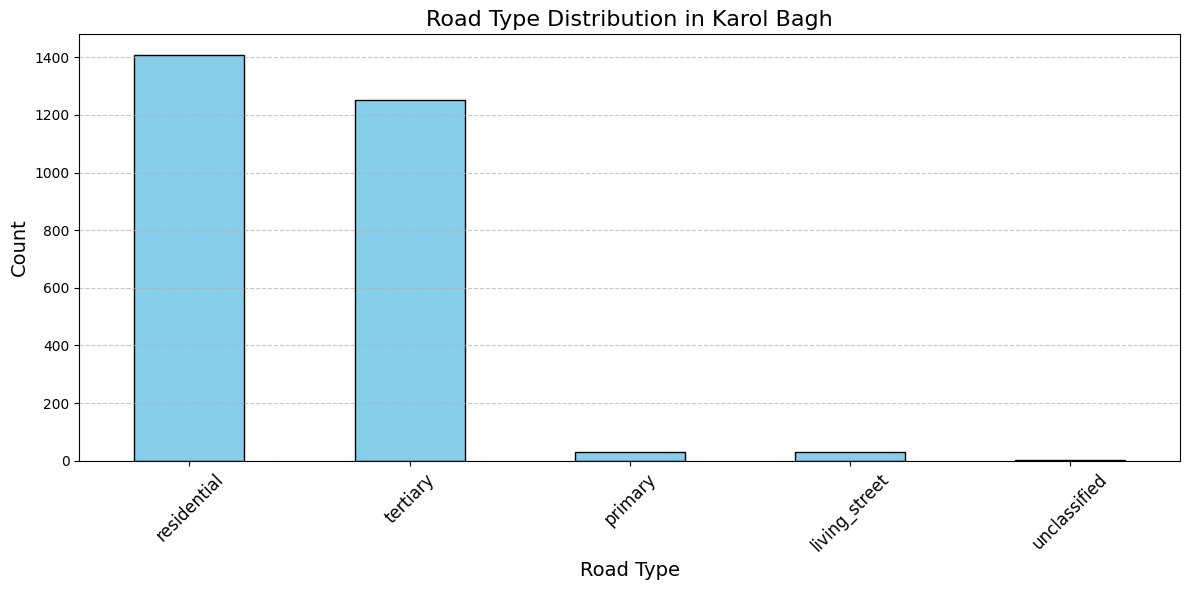

In [22]:
# Extract edge data
edges = ox.graph_to_gdfs(graph, nodes=False)

# Count road types
road_types = edges['highway'].explode().value_counts()  # Handles multiple highway tags per edge

print("Road Type Distribution:")
print(road_types)

# Plot road type distribution
plt.figure(figsize=(12, 6))
road_types.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Road Type Distribution in Karol Bagh", fontsize=16)
plt.xlabel("Road Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [32]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 66.8 MB/s eta 0:00:00:00:0100:01


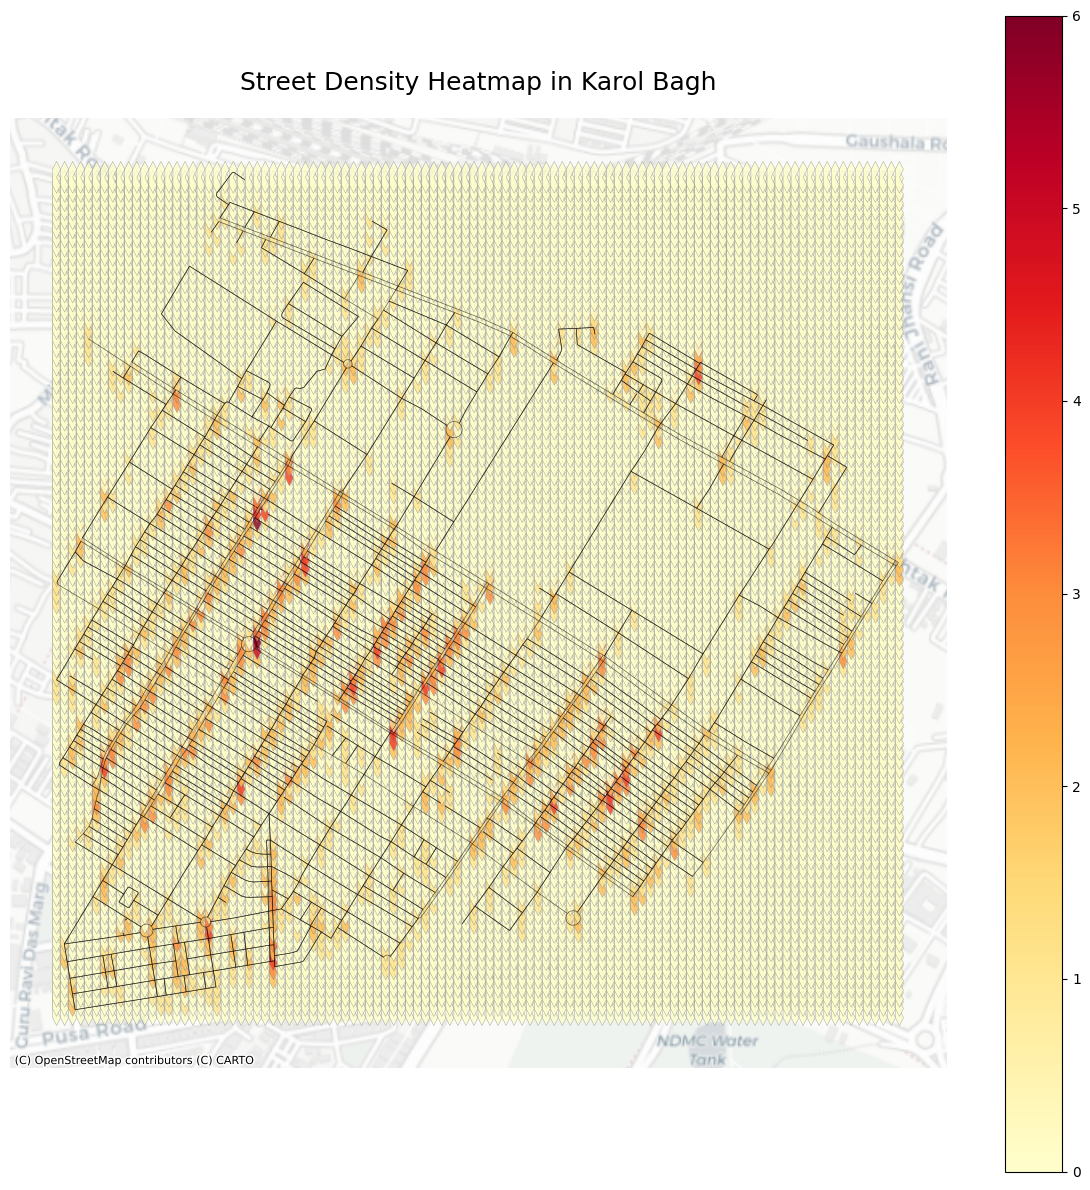

In [34]:
import contextily as ctx

# Load the graph for Karol Bagh
place = "Karol Bagh, Delhi, India"
graph = ox.graph_from_place(place, network_type="drive")

# Extract nodes as GeoDataFrame
nodes, edges = ox.graph_to_gdfs(graph)

# Define the bounding box of the graph
xmin, ymin, xmax, ymax = nodes.total_bounds

# Define the size of the hexagons (adjusted for better resolution)
hex_size = 0.0002  # Approximately 20m (in degrees), for more precision

# Generate a hexagonal grid
x_points = np.arange(xmin, xmax + hex_size, hex_size)
y_points = np.arange(ymin, ymax + hex_size, hex_size)
hexagons = []
for x in x_points:
    for y in y_points:
        hexagon = Polygon([
            (x, y),
            (x + hex_size / 2, y + hex_size * np.sqrt(3) / 2),
            (x, y + hex_size * np.sqrt(3)),
            (x - hex_size / 2, y + hex_size * np.sqrt(3) / 2),
            (x - hex_size / 2, y - hex_size * np.sqrt(3) / 2),
            (x, y - hex_size * np.sqrt(3)),
            (x + hex_size / 2, y - hex_size * np.sqrt(3) / 2),
            (x, y)
        ])
        hexagons.append(hexagon)

hex_gdf = gpd.GeoDataFrame({"geometry": hexagons}, crs=nodes.crs)

# Spatial join: count nodes within each hexagon
sjoined = gpd.sjoin(hex_gdf, nodes, predicate="contains")
density_counts = sjoined.groupby(sjoined.index).size()
hex_gdf["density"] = density_counts  # Assign counts to hexagons
hex_gdf["density"] = hex_gdf["density"].fillna(0)  # Fill NaN with 0 for empty hexagons

# Plot the hexagonal density heatmap
fig, ax = plt.subplots(figsize=(12, 12))
hex_gdf.plot(
    column="density",
    cmap="YlOrRd",
    ax=ax,
    legend=True,
    edgecolor="grey",
    linewidth=0.3,
    alpha=0.8,
)

# Overlay street network for context
edges.plot(ax=ax, color="black", linewidth=0.5, alpha=0.6)

# Add basemap (real-world map)
ctx.add_basemap(ax, crs=hex_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Final touches
plt.title("Street Density Heatmap in Karol Bagh", fontsize=18, pad=20)
plt.axis("off")
plt.tight_layout()
plt.show()
